In [ ]:
!unzip /Data.zip

# 🛠️ **Building Image classification using pretrained ViT models**
## 1. Overview
This script is designed to fine tune BEiT model on building image dataset.


# 2. Import Libraries (PyTorch & Hugging Face)
We are switching frameworks here from TensorFlow to **PyTorch**, which is the industry standard for research and Transformer models.
* **`torch`**: The core deep learning library.
* **`transformers`**: Provided by Hugging Face. We import `BeitForImageClassification`, which is a specific type of Vision Transformer called **BEiT** (Bidirectional Encoder representation from Image Transformers).
* **`GradScaler` / `autocast`**: Tools for **Mixed Precision Training**. This makes the model run faster and use less memory by using 16-bit math instead of 32-bit where possible.

In [1]:
## Final Code used to train the BIET MODEL
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from transformers import BeitForImageClassification, BeitConfig
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from pathlib import Path
import time
import json

# 3. Setup Checkpoints & Logging
Training Transformers can be computationally expensive. We create directories to:
1.  **Checkpoints:** Save the model's weights automatically whenever it improves.
2.  **Logs:** Save the training history (loss, accuracy) so we can analyze it later.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

checkpoint_dir = '/content/drive/MyDrive/AI4DRR Workshop/ViT_checkpoints'
training_logs_dir = '/content/drive/MyDrive/AI4DRR Workshop/ViT_training_logs'
# Create the directory if it does not exist
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(training_logs_dir, exist_ok=True)

print("Checkpoint directory created at:", checkpoint_dir)

Checkpoint directory created at: /content/drive/MyDrive/AI4DRR Workshop/ViT_checkpoints


# 4. The Trainer Class (The Engine)
This is the core of our script. Unlike Keras (which hides logic behind `.fit()`), PyTorch requires us to define the training loop manually. This class handles everything:

### A. Data Preparation (`_setup_data`)
* **Transforms:** We resize images to `224x224` and normalize them using specific Mean/Std values required by the BEiT model.
* **Weighted Random Sampler:** **(Crucial Step)** Our dataset might be imbalanced (e.g., more "RCC" buildings than "Vacant"). This sampler forces the model to pick rare classes more often, ensuring it learns them equally well.

### B. The Model: BEiT (`_setup_model`)
We load `microsoft/beit-base-patch16...`.
* **What is BEiT?** Instead of looking at pixels like a CNN, it breaks the image into "patches" (like words in a sentence) and uses self-attention to understand the relationship between different parts of the building.
* **Progressive Unfreezing:** We freeze most of the model but **unfreeze** the last few layers (Layers 5-11 and the Classifier). This allows the model to adapt to our specific building types without forgetting the general features it learned from ImageNet.

### C. Optimization (`_setup_training`)
* **Optimizer:** We use `AdamW`, the standard optimizer for Transformers.
* **Scheduler:** `CosineAnnealingWarmRestarts`. This adjusts the learning rate up and down like a wave, helping the model escape "local minima" (bad solutions) and find the best solution.
* **Loss Function:** We use `CrossEntropyLoss` with **Label Smoothing**. This prevents the model from being "overconfident" (e.g., predicting 100% probability), which improves generalization.

In [4]:
class BEiTTrainer:
    def __init__(
        self,
        data_dir,
        num_classes,
        batch_size=10,
        learning_rate=5e-6,
        train_split=0.8,
        image_size=224,
        num_workers=10,
        checkpoint_dir='/content/drive/MyDrive/AI4DRR Workshop/ViT_checkpoints'
    ):
        self.data_dir = data_dir
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.train_split = train_split
        self.image_size = image_size
        self.num_workers = num_workers
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(exist_ok=True)

        self.log_dir = Path('/content/drive/MyDrive/AI4DRR Workshop/ViT_training_logs')
        self.log_dir.mkdir(exist_ok=True)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # Lists to store metrics
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.train_class_accuracies = []  # Per-class accuracy for training
        self.val_class_accuracies = []    # Per-class accuracy for validation

        self._setup_data()
        self._setup_model()
        self._setup_training()

    def _setup_data(self):
        # BEiT specific transforms
        data_transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # BEiT normalization
        ])

        # Load dataset
        full_dataset = datasets.ImageFolder(self.data_dir, transform=data_transform)

        # Calculate splits
        train_size = int(self.train_split * len(full_dataset))
        val_size = len(full_dataset) - train_size

        # Create splits with fixed seed
        generator = torch.Generator().manual_seed(42)
        self.train_dataset, self.val_dataset = random_split(
            full_dataset, [train_size, val_size], generator=generator
        )

        # Calculate class weights for balanced sampling
        labels = [full_dataset.targets[i] for i in self.train_dataset.indices]
        class_counts = torch.bincount(torch.tensor(labels))
        class_weights = 1.0 / class_counts.float()
        sample_weights = [class_weights[label] for label in labels]
        self.sampler = torch.utils.data.WeightedRandomSampler(
            sample_weights, len(sample_weights), replacement=True
        )

        # Create data loaders with balanced sampling
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            sampler=self.sampler,
            num_workers=self.num_workers,
            pin_memory=True
        )

        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

    def _setup_model(self):
        # Initialize BEiT model with custom configuration
        config = BeitConfig.from_pretrained(
            "microsoft/beit-base-patch16-224-pt22k-ft22k",
            num_labels=self.num_classes,
            id2label={str(i): str(i) for i in range(self.num_classes)},
            label2id={str(i): i for i in range(self.num_classes)}
        )

        self.model = BeitForImageClassification.from_pretrained(
            "microsoft/beit-base-patch16-224-pt22k-ft22k",
            config=config,
            ignore_mismatched_sizes=True
        )

        # Progressive unfreezing of layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze specific layers for fine-tuning
        trainable_layers = [
            'pooler',
            'classifier',
            'encoder.layer.11',
            'encoder.layer.10',
            'encoder.layer.9',
            'encoder.layer.8',
            'encoder.layer.7',
            'encoder.layer.6',
            'encoder.layer.5'
        ]

        for name, param in self.model.named_parameters():
            if any(layer in name for layer in trainable_layers):
                param.requires_grad = True

        self.model = self.model.to(self.device)

    def _setup_training(self):
        # Use label smoothing and class weights
        class_counts = torch.bincount(torch.tensor(self.train_dataset.dataset.targets))
        class_weights = 1.0 / class_counts.float()
        class_weights = class_weights.to(self.device)
        self.criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

        # Separate parameter groups with different learning rates
        encoder_params = []
        head_params = []

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                if any(x in name for x in ['pooler', 'classifier']):
                    head_params.append(param)
                else:
                    encoder_params.append(param)

        # Modified optimizer settings
        self.optimizer = optim.AdamW([
            {'params': encoder_params, 'lr': self.learning_rate * 0.1},
            {'params': head_params, 'lr': self.learning_rate}
        ], weight_decay=0.08)

        # Cosine annealing with warm restarts
        self.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer,
            T_0=5,
            T_mult=2,
            eta_min=1e-6
        )

        self.scaler = GradScaler()

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        class_correct = torch.zeros(self.num_classes, device=self.device)
        class_total = torch.zeros(self.num_classes, device=self.device)

        pbar = tqdm(self.train_loader, desc='Training')
        for batch_idx, (images, targets) in enumerate(pbar):
            images, targets = images.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad(set_to_none=True)

            with autocast():
                outputs = self.model(images)
                loss = self.criterion(outputs.logits, targets)

            self.scaler.scale(loss).backward()

            # Gradient clipping
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Per-class accuracy
            for i in range(self.num_classes):
                mask = targets == i
                class_correct[i] += predicted[mask].eq(targets[mask]).sum().item()
                class_total[i] += mask.sum().item()

            pbar.set_postfix({
                'loss': total_loss / (batch_idx + 1),
                'acc': 100. * correct / total
            })

        self.scheduler.step()

        # Calculate per-class accuracy
        class_accuracies = []
        for i in range(self.num_classes):
            if class_total[i] > 0:
                class_accuracies.append(100. * class_correct[i] / class_total[i])
            else:
                class_accuracies.append(float('nan'))  # If no samples for this class

        return total_loss / len(self.train_loader), 100. * correct / total, class_accuracies

    @torch.no_grad()
    def validate(self):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        class_correct = torch.zeros(self.num_classes, device=self.device)
        class_total = torch.zeros(self.num_classes, device=self.device)

        for images, targets in tqdm(self.val_loader, desc='Validating'):
            images, targets = images.to(self.device), targets.to(self.device)

            with autocast():
                outputs = self.model(images)
                loss = self.criterion(outputs.logits, targets)

            total_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Per-class accuracy
            for i in range(self.num_classes):
                mask = targets == i
                class_correct[i] += predicted[mask].eq(targets[mask]).sum().item()
                class_total[i] += mask.sum().item()

        # Calculate per-class accuracy
        class_accuracies = []
        for i in range(self.num_classes):
            if class_total[i] > 0:
                class_accuracies.append(100. * class_correct[i] / class_total[i])
            else:
                class_accuracies.append(float('nan'))  # If no samples for this class

        return total_loss / len(self.val_loader), 100. * correct / total, class_accuracies

    def train(self, num_epochs=50):
        print("Starting training...")
        start_time = time.time()
        best_val_acc = 0
        patience = 10
        no_improve = 0

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")

            train_loss, train_acc, train_class_acc = self.train_epoch()
            val_loss, val_acc, val_class_acc = self.validate()

            # Store metrics
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            self.train_class_accuracies.append(train_class_acc)
            self.val_class_accuracies.append(val_class_acc)

            # Print metrics
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

            # Save checkpoint
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                self.save_checkpoint(epoch, val_loss, val_acc, is_best=True)
                no_improve = 0
                print("New best model saved!")
            else:
                no_improve += 1
                if no_improve >= patience:
                    print("Early stopping triggered!")
                    break

            # Save logs
            self.save_logs(epoch)

        print(f"\nTraining completed. Best validation accuracy: {best_val_acc:.2f}%")

    def save_checkpoint(self, epoch, val_loss, val_acc, is_best=False):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc
        }

        if is_best:
            torch.save(checkpoint, self.checkpoint_dir / 'best_model.pth')
        else:
            torch.save(checkpoint, self.checkpoint_dir / f'checkpoint_epoch_{epoch}.pth')

    def save_logs(self, epoch):
        # Convert tensors to Python lists or floats
        train_class_acc = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in self.train_class_accuracies[-1]]
        val_class_acc = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in self.val_class_accuracies[-1]]

        log_data = {
            'epoch': epoch,
            'train_loss': self.train_losses[-1],
            'train_acc': self.train_accuracies[-1],
            'val_loss': self.val_losses[-1],
            'val_acc': self.val_accuracies[-1],
            'train_class_acc': train_class_acc,  # Converted to Python list
            'val_class_acc': val_class_acc      # Converted to Python list
        }

        # Save logs to a JSON file
        with open(self.log_dir / f'epoch_{epoch}.json', 'w') as f:
            json.dump(log_data, f, indent=4)

# 5. Start Training
We instantiate the `BEiTTrainer` and begin the process.
* **Hyperparameters:**
    * `batch_size=10`: Fits on standard Colab GPUs.
    * `learning_rate=5e-5`: Transformers are sensitive; we use a very small learning rate.
    * `num_epochs=40`: Transformers often need more epochs to converge compared to CNNs.

In [16]:
!rm -r "/content/drive/MyDrive/AI4DRR Workshop/Data/.ipynb_checkpoints"

In [17]:
# Usage
if __name__ == "__main__":
    trainer = BEiTTrainer(
        data_dir="/content/drive/MyDrive/AI4DRR Workshop/Data",
        num_classes=4,
        batch_size=10,
        learning_rate=5e-5
    )
    trainer.train(num_epochs=1)

Using device: cpu


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4294419272.py:158: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()


Starting training...

Epoch 1/1


Training:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipython-input-4294419272.py:174: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validating:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipython-input-4294419272.py:227: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validating: 100%|██████████| 3/3 [00:22<00:00,  7.63s/it]


Train Loss: 1.2346, Train Acc: 44.79%
Val Loss: 1.0435, Val Acc: 70.83%
New best model saved!

Training completed. Best validation accuracy: 70.83%


# 🧪 Model Evaluation: BEiT Inference & Performance Metrics

This cell contains the complete pipeline to load the best saved checkpoint, run inference on the test dataset, and calculate comprehensive performance metrics for the **BEiT (Bidirectional Encoder Representation from Image Transformers)** model.

### 📋 Workflow Overview

1.  **Model Initialization**:
    * Reconstructs the `BeitForImageClassification` architecture using the `microsoft/beit-base-patch16-224-pt22k-ft22k` configuration.
    * Loads the trained weights (`best_model.pth`) onto the active device (GPU/CPU).
    * **Note**: The loader handles both full-model saves and state-dictionary saves automatically.

2.  **Data Preparation**:
    * Uses `torchvision.datasets.ImageFolder` to infer class labels from directory names.
    * Applies standard normalization (mean=`0.5`, std=`0.5`) and resizing (`224x224`) to match the training phase.

3.  **Inference Loop**:
    * Iterates through the test dataset using `torch.no_grad()` to minimize memory usage.
    * Collects both Ground Truth (`y_true`) and Model Predictions (`y_pred`).

4.  **Performance Metrics**:
    The script calculates the following metrics to ensure a robust evaluation, particularly if classes are imbalanced:
    * **Accuracy**: The ratio of correctly predicted observations to total observations.
    * **F1-Score (Weighted)**: The harmonic mean of Precision and Recall. Weighted averaging accounts for class imbalances.
    * **Matthews Correlation Coefficient (MCC)**: A correlation coefficient between observed and predicted binary classifications; it returns a value between -1 and +1. A coefficient of +1 represents a perfect prediction.

5.  **Visualization**:
    * Generates a **Confusion Matrix** using `sklearn` and visualizes it as a Heatmap using `seaborn`.
    * Saves the resulting plot to `OUTPUT_PLOT_PATH`.

Using device: cpu
Classes found: ['Assam_Type', 'Metal_Sheet', 'RCC', 'Vacant']
Loading model from /content/drive/MyDrive/AI4DRR Workshop/ViT_checkpoints/best_model.pth...


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running inference on test data...


Evaluating: 100%|██████████| 4/4 [01:34<00:00, 23.71s/it]



PERFORMANCE METRICS
Accuracy: 60.00%
F1-Score (Weighted): 0.5805
Matthews Correlation Coefficient (MCC): 0.4710
--------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

  Assam_Type       0.57      0.57      0.57        30
 Metal_Sheet       0.45      0.30      0.36        30
         RCC       0.72      0.97      0.83        30
      Vacant       0.57      0.57      0.57        30

    accuracy                           0.60       120
   macro avg       0.58      0.60      0.58       120
weighted avg       0.58      0.60      0.58       120


Confusion matrix plot saved to: /content/drive/MyDrive/AI4DRR Workshop/confusion_matrix.png


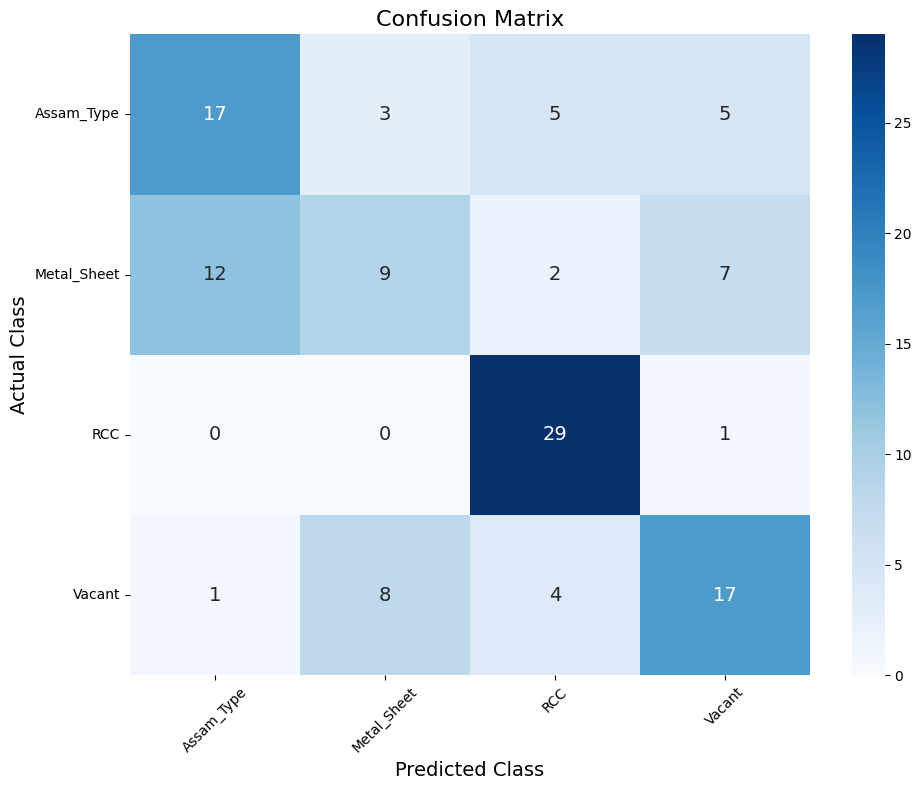

In [21]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import BeitForImageClassification, BeitConfig
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path

# ==========================================
# CONFIGURATION
# ==========================================
MODEL_PATH = '/content/drive/MyDrive/AI4DRR Workshop/ViT_checkpoints/best_model.pth'
TEST_DATA_DIR = '/content/drive/MyDrive/AI4DRR Workshop/Data' # Folder with class subfolders
OUTPUT_PLOT_PATH = '/content/drive/MyDrive/AI4DRR Workshop/confusion_matrix.png'
NUM_CLASSES = 4
BATCH_SIZE = 32
IMAGE_SIZE = 224

def load_trained_model(model_path, num_classes, device):
    """Loads the trained BEiT model and weights."""
    print(f"Loading model from {model_path}...")

    # 1. Configure Model Structure
    config = BeitConfig.from_pretrained(
        "microsoft/beit-base-patch16-224-pt22k-ft22k",
        num_labels=num_classes,
        id2label={str(i): str(i) for i in range(num_classes)},
        label2id={str(i): i for i in range(num_classes)}
    )

    model = BeitForImageClassification.from_pretrained(
        "microsoft/beit-base-patch16-224-pt22k-ft22k",
        config=config,
        ignore_mismatched_sizes=True
    )

    # 2. Load Weights
    checkpoint = torch.load(model_path, map_location=device)

    # Handle different saving formats (dict vs entire model)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    model.to(device)
    model.eval()
    return model

def get_predictions(model, data_loader, device):
    """Iterates through the dataset and returns true and predicted labels."""
    all_preds = []
    all_labels = []

    print("Running inference on test data...")
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs.logits, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

def plot_confusion_matrix(y_true, y_pred, class_names, save_path):
    """Plots and saves a confusion matrix using Seaborn."""
    cm = confusion_matrix(y_true, y_pred)

    # Create a DataFrame for better labeling
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=True, annot_kws={"size": 14})

    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('Actual Class', fontsize=14)
    plt.xlabel('Predicted Class', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save the plot
    plt.savefig(save_path, dpi=300)
    print(f"\nConfusion matrix plot saved to: {save_path}")
    plt.show()

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1. Setup Data Transforms (Same as training)
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # 2. Load Dataset
    # We use ImageFolder to automatically get labels from folder names
    dataset = datasets.ImageFolder(TEST_DATA_DIR, transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    class_names = dataset.classes
    print(f"Classes found: {class_names}")

    # 3. Load Model
    model = load_trained_model(MODEL_PATH, NUM_CLASSES, device)

    # 4. Get Predictions
    y_true, y_pred = get_predictions(model, dataloader, device)

    # 5. Calculate Metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted') # Weighted F1 accounts for class imbalance
    mcc = matthews_corrcoef(y_true, y_pred)

    # 6. Print Report
    print("\n" + "="*50)
    print("PERFORMANCE METRICS")
    print("="*50)
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    print("-" * 50)
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # 7. Plot Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, class_names, OUTPUT_PLOT_PATH)

if __name__ == "__main__":
    main()

# 📂 Automated Image Sorting & Classification Tool

This cell defines and executes the `ImageSorter` class, a utility designed to operationalize your trained BEiT model. It takes a directory of raw, unlabelled images and automatically organizes them into labeled subdirectories based on the model's predictions.

### ⚙️ How It Works



[Image of machine learning image classification pipeline]


1.  **Class Initialization (`__init__`)**:
    * Sets up the processing device (CUDA/CPU).
    * **Auto-Label Detection**: Dynamically reads the folder names from your `TRAINING_DATA_PATH` to ensure the sorter uses the exact same class labels as the training phase.
    * **Model Loading**: Reconstructs the BEiT architecture and loads your `best_model.pth` weights.

2.  **The Sorting Loop (`sort_images`)**:
    * **File Discovery**: Scans the `INPUT_IMAGES_PATH` for valid image files (.jpg, .png, etc.).
    * **Inference**: Preprocesses each image (resize & normalize) and passes it through the model.
    * **Organization**:
        * Determines the predicted class index (e.g., `0` becomes `Class_A`).
        * **Action**: Uses `shutil.copy2` to copy the image from the source folder to the corresponding class folder in `OUTPUT_SORTED_PATH`.

### 📝 Configuration

You must configure the paths at the bottom of the cell before running:
* `MODEL_PATH`: Location of your trained `.pth` file.
* `TRAINING_DATA_PATH`: Used *only* to read the folder names (labels).
* `INPUT_IMAGES_PATH`: The folder containing new, mixed images you want to sort.
* `OUTPUT_SORTED_PATH`: Where the code will create new folders and place the sorted images.

In [20]:
import os
import torch
import shutil
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from transformers import BeitForImageClassification, BeitConfig

class ImageSorter:
    def __init__(self, model_path, data_dir, input_source_dir, output_sorted_dir, num_classes=4):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.input_dir = Path(input_source_dir)
        self.output_dir = Path(output_sorted_dir)
        self.data_dir = Path(data_dir) # Used to retrieve class names

        print(f"Using device: {self.device}")

        # 1. Setup Class Names (Try to auto-detect from training folder)
        self.classes = self._get_class_names()
        print(f"Detected classes: {self.classes}")

        # 2. Setup Model
        self.model = self._load_model(model_path, num_classes)

        # 3. Setup Transforms (Must match training exactly)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def _get_class_names(self):
        """Attempts to read class names from the original training directory structure."""
        try:
            # Classes in ImageFolder are sorted alphabetically
            classes = sorted([d.name for d in self.data_dir.iterdir() if d.is_dir()])
            if not classes:
                raise ValueError("No subdirectories found")
            return classes
        except Exception as e:
            print(f"Warning: Could not auto-detect classes from {self.data_dir}. Using generic names.")
            # Fallback to generic names if training data isn't accessible
            return [str(i) for i in range(4)]

    def _load_model(self, model_path, num_classes):
        print(f"Loading model from {model_path}...")

        # Initialize Config
        config = BeitConfig.from_pretrained(
            "microsoft/beit-base-patch16-224-pt22k-ft22k",
            num_labels=num_classes,
            id2label={str(i): str(i) for i in range(num_classes)},
            label2id={str(i): i for i in range(num_classes)}
        )

        # Initialize Model Structure
        model = BeitForImageClassification.from_pretrained(
            "microsoft/beit-base-patch16-224-pt22k-ft22k",
            config=config,
            ignore_mismatched_sizes=True
        )

        # Load Weights
        checkpoint = torch.load(model_path, map_location=self.device)

        # KEY STEP: Your save function saved a dict, so we access 'model_state_dict'
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint) # Fallback if saved differently

        model = model.to(self.device)
        model.eval() # Set to evaluation mode
        return model

    def sort_images(self):
        # Create output directory
        if not self.output_dir.exists():
            self.output_dir.mkdir(parents=True)

        # Create subfolders for each class in the output directory
        for class_name in self.classes:
            (self.output_dir / class_name).mkdir(exist_ok=True)

        # Get list of images
        image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
        images = [f for f in self.input_dir.iterdir() if f.suffix.lower() in image_extensions]

        print(f"Found {len(images)} images to classify.")

        with torch.no_grad():
            for img_path in tqdm(images, desc="Sorting images"):
                try:
                    # Load and Preprocess
                    image = Image.open(img_path).convert('RGB')
                    input_tensor = self.transform(image).unsqueeze(0).to(self.device)

                    # Inference
                    outputs = self.model(input_tensor)
                    logits = outputs.logits
                    predicted_idx = logits.argmax(1).item()

                    # Map index to Class Name
                    predicted_class = self.classes[predicted_idx]

                    # Copy image to sorted folder
                    destination = self.output_dir / predicted_class / img_path.name
                    shutil.copy2(img_path, destination)

                except Exception as e:
                    print(f"Error processing {img_path.name}: {e}")

        print(f"\nSorting complete! Images are located in: {self.output_dir}")

# ==========================================
# CONFIGURATION - EDIT THESE PATHS
# ==========================================

# 1. Path to your best saved model
MODEL_PATH = '/content/drive/MyDrive/AI4DRR Workshop/ViT_checkpoints/best_model.pth'

# 2. Path to the original Training Data (Used only to get the folder names/labels)
TRAINING_DATA_PATH = '/content/drive/MyDrive/AI4DRR Workshop/Data'

# 3. Path to the folder containing NEW images you want to classify
INPUT_IMAGES_PATH = '/content/drive/MyDrive/AI4DRR Workshop/Test Data'

# 4. Where you want the sorted folders to be created
OUTPUT_SORTED_PATH = '/content/drive/MyDrive/AI4DRR Workshop/Sorted_Results'

# Create dummy input folder for testing if it doesn't exist (Optional)
if not os.path.exists(INPUT_IMAGES_PATH):
    os.makedirs(INPUT_IMAGES_PATH)
    print(f"Created empty input folder at {INPUT_IMAGES_PATH}. Please upload images there to test!")

# Run the sorter
if os.path.exists(INPUT_IMAGES_PATH) and len(os.listdir(INPUT_IMAGES_PATH)) > 0:
    sorter = ImageSorter(
        model_path=MODEL_PATH,
        data_dir=TRAINING_DATA_PATH,
        input_source_dir=INPUT_IMAGES_PATH,
        output_sorted_dir=OUTPUT_SORTED_PATH,
        num_classes=4 # Ensure this matches your trained model
    )
    sorter.sort_images()
else:
    print("Please upload some images to the 'Unsorted_Images' folder to run the classification.")

Using device: cpu
Detected classes: ['Assam_Type', 'Metal_Sheet', 'RCC', 'Vacant']
Loading model from /content/drive/MyDrive/AI4DRR Workshop/ViT_checkpoints/best_model.pth...


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found 16 images to classify.


Sorting images: 100%|██████████| 16/16 [00:23<00:00,  1.50s/it]


Sorting complete! Images are located in: /content/drive/MyDrive/AI4DRR Workshop/Sorted_Results
